# Portfolio Optimization



## 1. Original mean-variance model
### The Efficient Frontier : Markowitz portfolio optimization 

Modern Portfolio Theory is about how investors construct portfolios that maximizes returns for given
levels of risk.




In [58]:
# get data first from Quandl

import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime as dt
import quandl

quandl.ApiConfig.api_key = ''
tickers = ['CNP', 'F', 'WMT', 'GE']
## change tickers
data = quandl.get_table('WIKI/PRICES', ticker = tickers,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2009-05-01', 'lte': '2019-05-27' }, paginate=True)# 최근10년
clean = data.set_index('date')
table = clean.pivot(columns='ticker')

table.head(5)

adj_close                                
ticker           CNP         F         GE        WMT
date                                                
2009-05-01  7.387214  4.484893   9.657888  40.359445
2009-05-04  7.360376  4.630711   9.969924  40.996487
2009-05-05  7.226185  4.611006   9.969924  40.690062
2009-05-06  7.273152  4.934170  10.403729  39.923999
2009-05-07  7.279861  4.776529  10.624438  40.230424

#### can also use the below code box to import tickers from wiki.

# import tickers from Wikipedia

import pickle
import requests
import bs4 as bs
import lxml

web_add = 'http://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
request = requests.get(web_add)
soup = bs.BeautifulSoup(request.text,'html.parser')
table = soup.find('table',{'class': 'wikitable sortable'})
##download

tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker[:-1])
    

## What is the optimal portfolio among the various optimal combinations?
to get the efficient frontier, we need to simulate imaginary combinations of portfolios.  
we should select portfolio which has maximized return & skewness , as well as minimized risk &kurtosis.  


the paramont interest to investors to find what risk-return profiles are possible for a given set of financial instruments, and their statistical characertistics.

to make a list of situations, Monte Carlo simulation for generating random portfolio weight vectors is required.  
first, we should populate the empty lists with each portfolios returns, risk and weights.  
then, we will get expected portfolio return and variance in each simulated allocation.



In [2]:
#from IPython.display import Image
#Image(filename = 'C:/Users/user/Desktop/19_1/Financial_Data_with_python/sharp.jpeg')
import copy

In [171]:
# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean( ) * 250

n_returns_daily = pd.DataFrame(returns_daily)



df2 = pd.DataFrame(np.round(np.random.randn(2241, 4), 2),columns = [['adj_close','adj_close','adj_close','adj_close'],
                             ['CNP','F','GE','WMT']])

df2.index.names  = ['ticker']
df2['adj_close','CNP'] = 0.000654
df2['adj_close','F'] = 0.000576
df2['adj_close','GE']  = 0.000257
df2['adj_close','WMT'] = 0.000395

df2.head()


def returns(weights):
    return np.dot(weights,returns_annual)

def volatility(weights):
    return  np.sqrt(np.dot(weights.T, np.dot (cov_annual, weights)))

def kurtosis(weights):
    return  np.dot(weights.T,(n_returns_daily.reset_index(drop=True).sub(df2).fillna(0)**4).T).sum() / len(tickers)

def skewness(weights): 
    return np.dot(weights.T,(n_returns_daily.reset_index(drop=True).sub(df2).fillna(0)**3).T).sum() / len(tickers)




df_returns_daily = pd.DataFrame(returns_daily.mean())



# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily*250

# skewness

skew_daily = returns_daily.skew()
skew_annual = skew_daily*250

#kurtosis

kurt_daily = returns_daily.kurtosis()
kurt_annual = kurt_daily*250

port_returns = []
port_volatility = []

port_skewness = []
port_kurtosis = []

sharpe_ratio = []
stock_weights = []


# the number of combinations for imaginary portfolios
num_assets = len(tickers)
num_portfolios = 500


# set random seed for reproduction's sake
np.random.seed(101)



In [5]:
# np.dot(weights.T,(n_returns_daily.sub(df2).fillna(0)**3).T).sum()

In [60]:
returns_daily.head()

adj_close                              
ticker           CNP         F        GE       WMT
date                                              
2009-05-01       NaN       NaN       NaN       NaN
2009-05-04 -0.003633  0.032513  0.032309  0.015784
2009-05-05 -0.018232 -0.004255  0.000000 -0.007474
2009-05-06  0.006500  0.070085  0.043511 -0.018827
2009-05-07  0.000923 -0.031949  0.021214  0.007675

In [65]:
np.dot(weights.T,(n_returns_daily.sub(df2).fillna(0)**3).T).sum() / len(tickers)

0.0

In [84]:
n_returns_daily.reset_index(drop=True).sub(df2).head()

adj_close                              
ticker       CNP         F        GE       WMT
0            NaN       NaN       NaN       NaN
1      -0.004287  0.031937  0.032052  0.015389
2      -0.018886 -0.004831 -0.000257 -0.007869
3       0.005846  0.069509  0.043254 -0.019222
4       0.000269 -0.032525  0.020957  0.007280

In [85]:
df2.head()

adj_close                              
             CNP         F        GE       WMT
ticker                                        
0       0.000654  0.000576  0.000257  0.000395
1       0.000654  0.000576  0.000257  0.000395
2       0.000654  0.000576  0.000257  0.000395
3       0.000654  0.000576  0.000257  0.000395
4       0.000654  0.000576  0.000257  0.000395

In [172]:
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets) # make random numbers 
    weights /= np.sum(weights) # random portfolio weights
    
    p_returns = np.dot(weights,returns_annual) #product of vector and matrix
    
    p_volatility = np.sqrt(np.dot(weights.T, np.dot (cov_annual, weights)))
    
    sharpe = p_returns / p_volatility
    
    sharpe_ratio.append(sharpe)
    
    port_returns.append(returns(weights))
    
    port_volatility.append(volatility(weights))
    
    port_skewness.append(skewness(weights))
    
    port_kurtosis.append(kurtosis(weights))
    
    stock_weights.append(weights)


In [87]:
# a dictionary for returns and risk values of each portfolio
portfolio = {'Returns':port_returns,'Volatility':port_volatility, 'Sharpe Ratio':sharpe_ratio}

# extended original dictionary to accomadate each ticke and weight in the portfolio
for counter,symbol in enumerate(tickers):
    portfolio[symbol + 'Weight'] = [Weight[counter] for Weight in stock_weights]
    
df = pd.DataFrame(portfolio)

column_order = ['Returns','Volatility','Sharpe Ratio'] + [stock + 'Weight' for stock in tickers]

df = df[column_order]




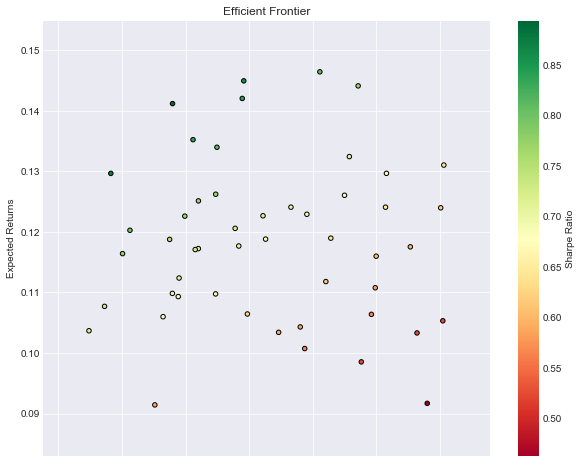

In [174]:
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()



# Optimal Portfolios


We will test 3 methods:
1. minimize portfolio variance

2. equal weights

3. maximizing return(mean) & skewness , minimizing risk(variance) &kurtosis
this model is extended from Markowitz's mean-variance model.

In [90]:
import scipy.optimize as sco

In [14]:
#this minimize fiunction is quite genral and allows for equality constaraints,
#inequility constraints, anc numerical bounds for the parameters


In [175]:
cons = ({'type':'eq','fun' : lambda x : np.sum(x) - 1}) #equality constraint

bnds = tuple((0,1) for x in range(num_assets))  #bonds for the parameters

eweights = np.array(num_assets* [1. / num_assets,]) #equal weights vector
eweights




array([0.25, 0.25, 0.25, 0.25])

### minimize portfolio variance
- minimum volatility
- minimum variance portfolio


In [176]:
optv = sco.minimize(volatility, eweights, method = 'SLSQP', bounds = bnds, constraints = cons)

optv

     fun: 0.14076467102770465
     jac: array([0.14145519, 0.14099785, 0.14006851, 0.14048788])
 message: 'Optimization terminated successfully.'
    nfev: 31
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.32602012, 0.02572137, 0.12348349, 0.52477502])

In [177]:
optv['x'].round(4)

array([0.326 , 0.0257, 0.1235, 0.5248])

In [178]:
volatility(optv['x']).round(4)




0.1408

In [179]:
returns(optv['x']).round(4)

0.1168

### Equal weights



In [180]:
cons = ({'type':'eq','fun' : lambda x : np.sum(x) - 1}) #equality constraint

bnds = tuple((0,1) for x in range(num_assets))  #bonds for the parameters

equal_weights = np.array(num_assets* [1. / num_assets,]) #equal weights vector
equal_weights


array([0.25, 0.25, 0.25, 0.25])

In [181]:
volatility(equal_weights).round(4)

0.1636

In [182]:
returns(equal_weights).round(4)

0.1177

### maximizing return(mean) & skewness , minimizing risk(variance) &kurtosis

- extended Markowitz's model





In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KDTree
from pandas.plotting import scatter_matrix
from scipy.spatial import ConvexHull



In [183]:
rn = lambda weights : returns(weights)

optm = sco.minimize(lambda x : -rn(weights), eweights, method = 'SLSQP', bounds =bnds, constraints = cons)

-optm.fun

0.08711860582116725

In [184]:
ske = lambda weights : skewness(weights)

opts = sco.minimize(lambda x : -ske(weights), eweights, method = 'SLSQP', bounds =bnds, constraints = cons)

-opts.fun

6.78341230554208e-05

In [185]:
opts = sco.minimize(skewness, eweights, method = 'SLSQP', bounds =bnds, constraints = cons)

In [186]:

optk = sco.minimize(kurtosis, eweights, method = 'SLSQP', bounds =bnds, constraints = cons)



In [187]:
optm

     fun: -0.08711860582116725
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 6
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.25, 0.25, 0.25, 0.25])

In [188]:
optv


     fun: 0.14076467102770465
     jac: array([0.14145519, 0.14099785, 0.14006851, 0.14048788])
 message: 'Optimization terminated successfully.'
    nfev: 31
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.32602012, 0.02572137, 0.12348349, 0.52477502])

In [189]:
opts

     fun: -0.0014625629747223039
     jac: array([ 7.23574485e-05, -1.46256300e-03,  2.21286871e-04, -1.12604510e-04])
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([1.56125113e-16, 1.00000000e+00, 3.45888664e-16, 5.48172618e-16])

In [190]:
optk

     fun: 0.0002780843231778929
     jac: array([8.75172591e-05, 6.97933261e-04, 1.89665057e-04, 1.37221719e-04])
 message: 'Optimization terminated successfully.'
    nfev: 6
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.25, 0.25, 0.25, 0.25])

In [191]:
Mstar = -optm.fun
Vstar = optv.fun
Sstar = -opts.fun
Kstar = optk.fun
"""
calculates the optimal portfolio weights for utility functions that uses mean, variance, skewness, kurtosis

delta1: codfficient of mean(how much weight to give maximizing mean)
    delta2: coefficient of variance( how much ewight to give minimizing covarince)
    delta3: coefficient of skew(how much weight to give mazimizing skew)
    delta4: coefficient of kurtosis(how much weight to give minimizing kurtosis)

"""

delta1 = Mstar - returns(weights) 
delta2 = Vstar - volatility(weights)  
delta3 = Sstar - skewness(weights) 
delta4 = Kstar - kurtosis(weights) 


lambda1 = 1
lambda2 = 1
lambda3 = 1
lambda4 = 0

#np.dot(weights,eye(num_assets)) = 1

def objective_func(weights):
    return abs(delta1/Mstar)**lambda1 + abs(delta2/Vstar)**lambda2 + abs(delta3/Sstar)**lambda3+ abs(delta4/Kstar)**lambda4

#objective function Z
objective_func(weights)


2.1114879885417874

In [192]:
optz = sco.minimize(objective_func, eweights, method = 'SLSQP', bounds = bnds, constraints = cons)
optz



     fun: 2.1114879885417874
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 6
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.25, 0.25, 0.25, 0.25])

In [193]:
#수익률이 +인지-인지로 분류해서 Knn??